In [1]:
from urllib.request import urlopen
from PIL import Image
import timm

model = timm.create_model('tf_mobilenetv3_large_minimal_100.in1k', pretrained=True)
model = model.eval()

data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

c:\Users\Wojciech\Desktop\ML-Advanced\Benchmark-of-Methods-for-Adversarial-Attacks\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


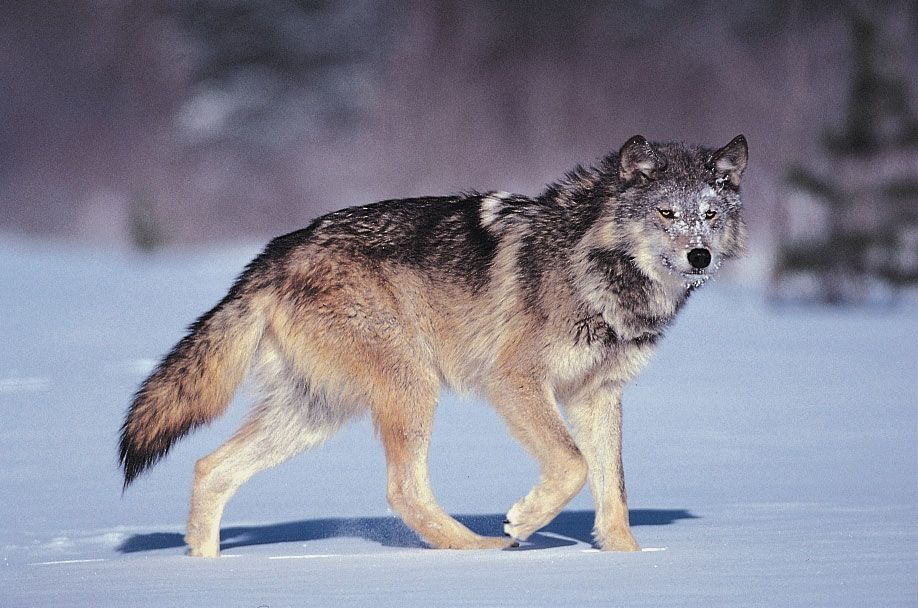

In [2]:
image = Image.open((urlopen("https://cdn.britannica.com/07/5207-050-5BC9F251/Gray-wolf.jpg")))
display(image)

This time we don't have easy access to labels as with ResNet-50, so we need to import them manually instead|

In [3]:
import requests

url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
imagenet_labels = requests.get(url).json()
display(imagenet_labels)

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead shark',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'American robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'American dipper',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'fire salamander',
 'smooth newt',
 'newt',
 'spotted salamander',
 'axolotl',
 'American bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead sea turtle',
 'leatherback sea turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'green iguana',
 'Carolina anole',
 'desert grassland whiptail lizard',
 'agama',
 'frilled-necked lizard',
 'alligator lizard',
 'Gila monster',
 'European green lizard',
 'chameleon',
 'Komodo dragon',
 'Nile crocodile',
 'American alligator',
 'triceratops',
 'worm snake',
 'ring-necked snake',
 'eastern hog-nosed snake',
 'smooth green snake',
 'kingsnake',
 'garter snake',
 'water snake',
 'vin

In [4]:
import torch

image_tensor = transforms(image).unsqueeze(0)

with torch.no_grad():
    logits = model(image_tensor)
probabilities = torch.nn.functional.softmax(logits, dim=-1)

pred_label_idx = torch.argmax(probabilities).item()
pred_label_name = imagenet_labels[pred_label_idx]

print(f"Predicted class name: {pred_label_name} (ID: {pred_label_idx} with certainty: {torch.max(probabilities).item()})")

Predicted class name: grey wolf (ID: 269 with certainty: 0.8373408317565918)


### Attacking model with Cleverhans PGD method

In [5]:
import numpy as np
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent


arr = np.zeros(1)
arr[0] = imagenet_labels.index('vulture')
target_class = torch.from_numpy(arr).to(dtype=torch.long)
adv_img = projected_gradient_descent(model, image_tensor, norm=np.inf, eps=0.3, eps_iter=0.1, nb_iter=100, targeted=True, y=target_class)

with torch.no_grad():
    logits = model(adv_img)
probabilities = torch.nn.functional.softmax(logits, dim=-1)

pred_label_idx = torch.argmax(probabilities).item()
pred_label_name = imagenet_labels[pred_label_idx]

print(f"Predicted class name: {pred_label_name} (ID: {pred_label_idx} with certainty: {torch.max(probabilities).item()})")

Predicted class name: suspension bridge (ID: 839 with certainty: 0.0861370638012886)


In [10]:
from cleverhans.tf2.attacks.carlini_wagner_l2 import carlini_wagner_l2
import tensorflow as tf
import torchvision

image_tensor_tf = tf.convert_to_tensor(image, dtype=tf.float32)

arr = np.zeros(1)
arr[0] = imagenet_labels.index('stingray')
target_class = tf.convert_to_tensor(arr, tf.float32)

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),  # MobileNetV3 input size
    torchvision.transforms.ToTensor(),
])

image_cw2 = transform(image).unsqueeze(0).numpy()
image_tensor_cw2 = tf.convert_to_tensor(image_cw2, dtype=tf.float32)


adv_img = carlini_wagner_l2(model, image_tensor_cw2)

with torch.no_grad():
    logits = model(adv_img)
probabilities = torch.nn.functional.softmax(logits, dim=-1)

pred_label_idx = tf.argmax(probabilities).item()
pred_label_name = imagenet_labels[pred_label_idx]

print(f"Predicted class name: {pred_label_name} (ID: {pred_label_idx} with certainty: {torch.max(probabilities).item()})")

AttributeError: EagerTensor object has no attribute 'size'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      